In [1]:
!pip install pyhepmc numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.5/577.5 kB 259.4 kB/s eta 0:00:00a 0:00:01


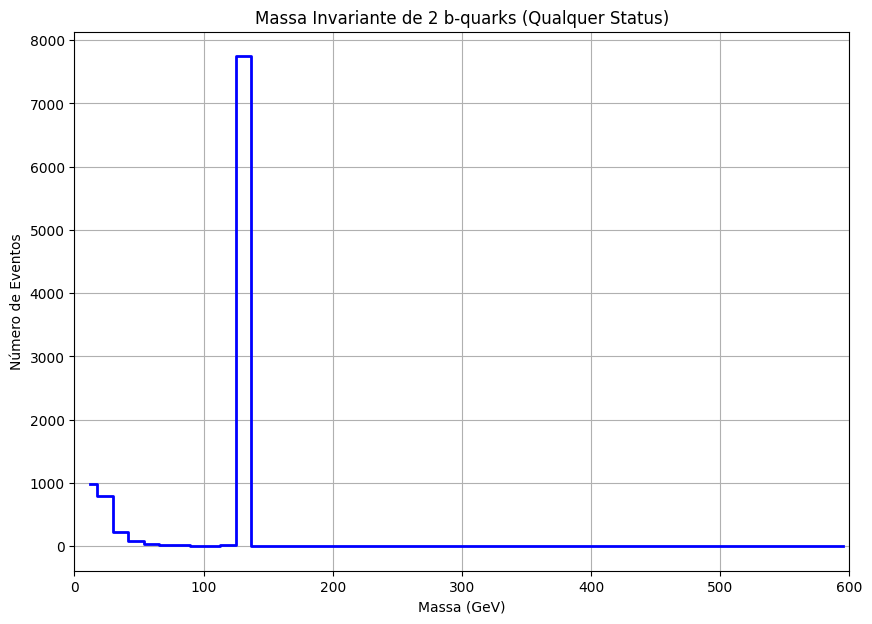

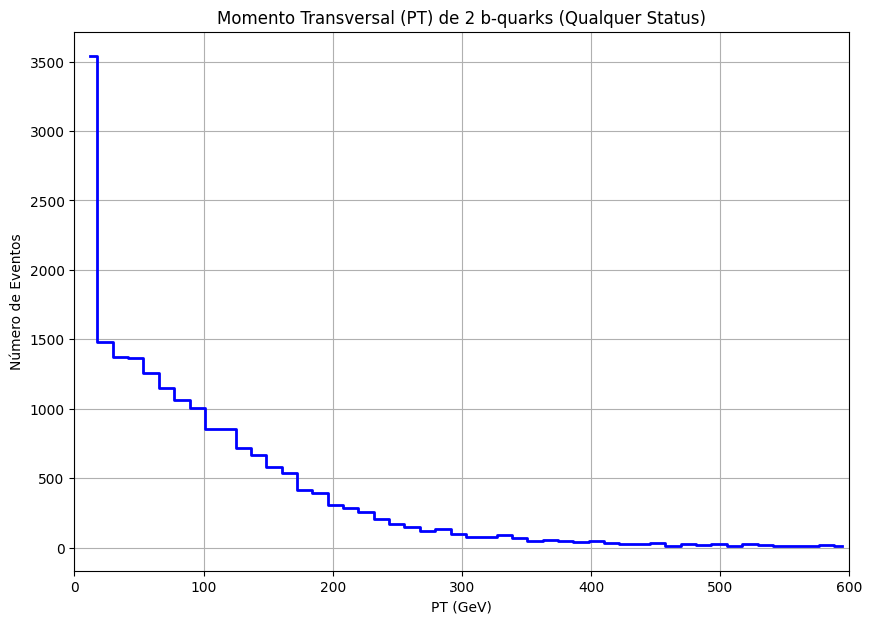

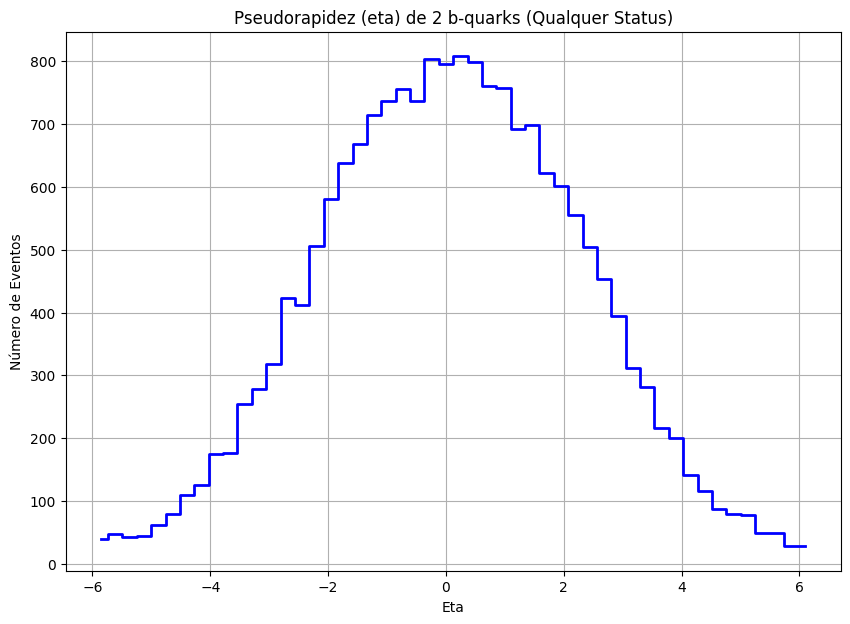

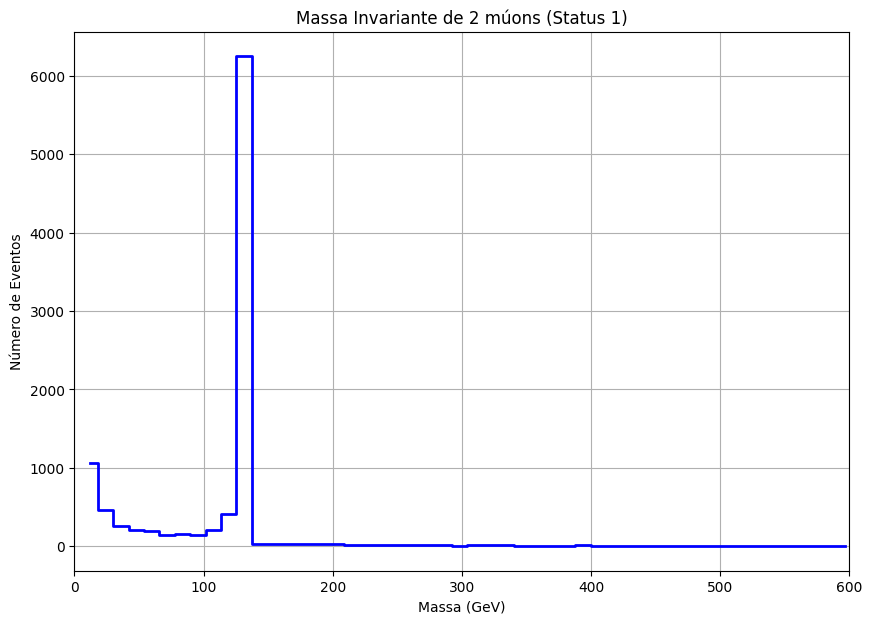

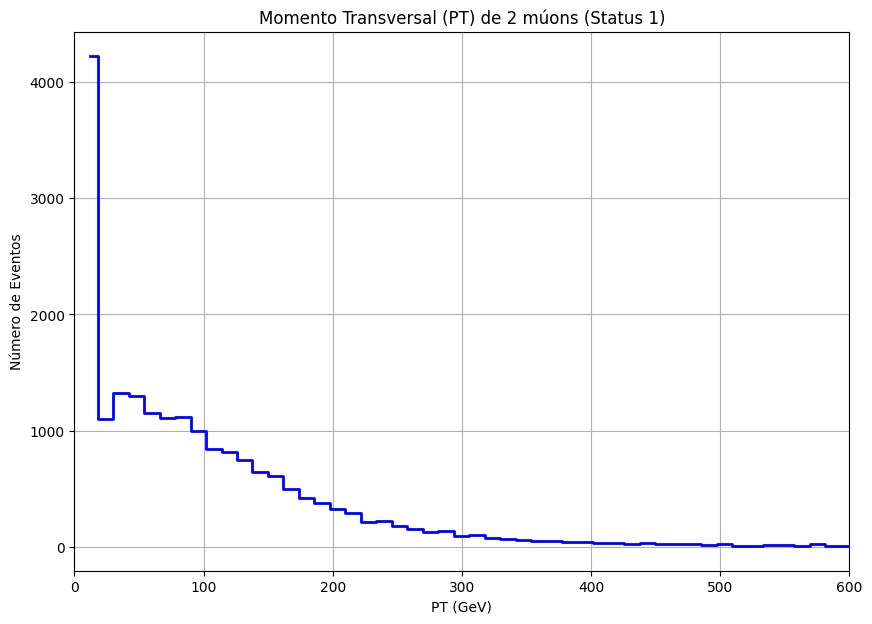

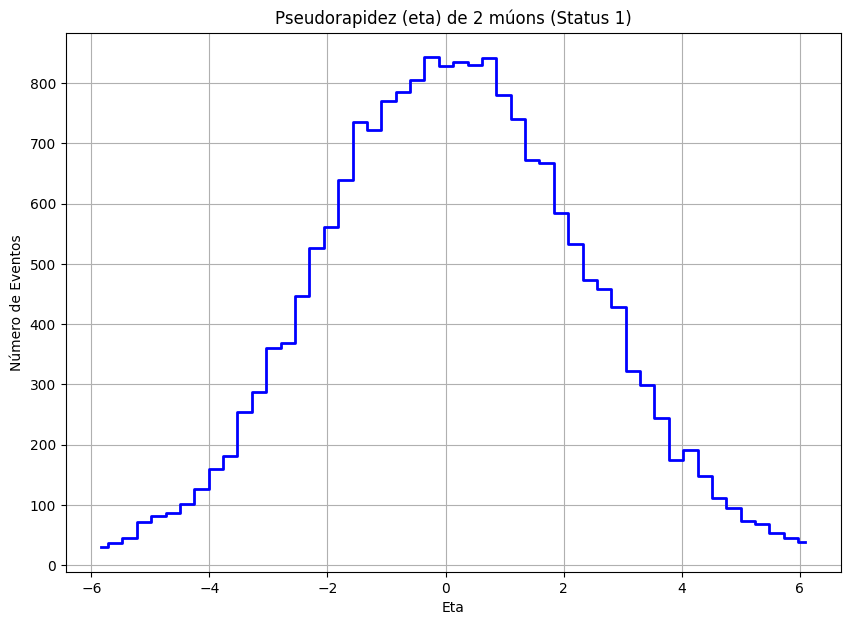

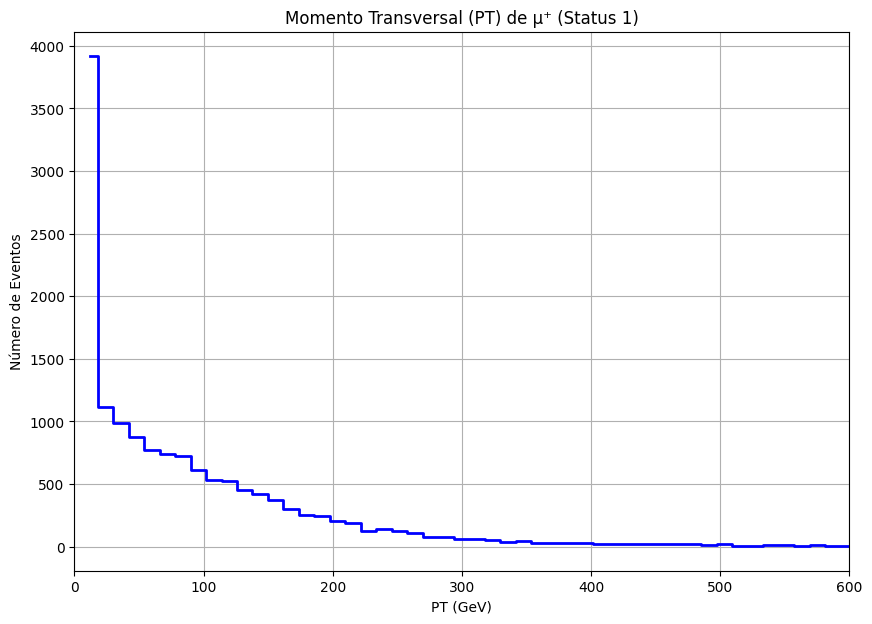

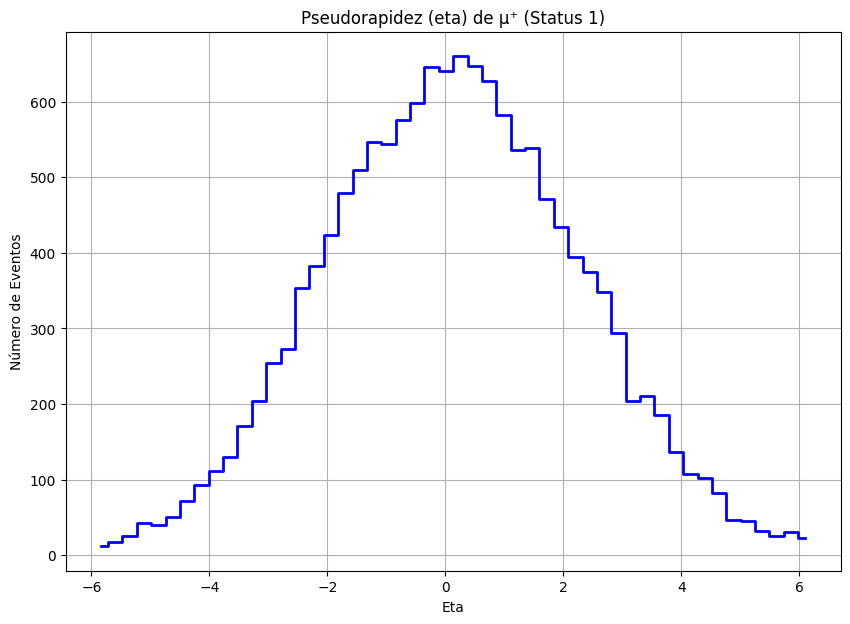

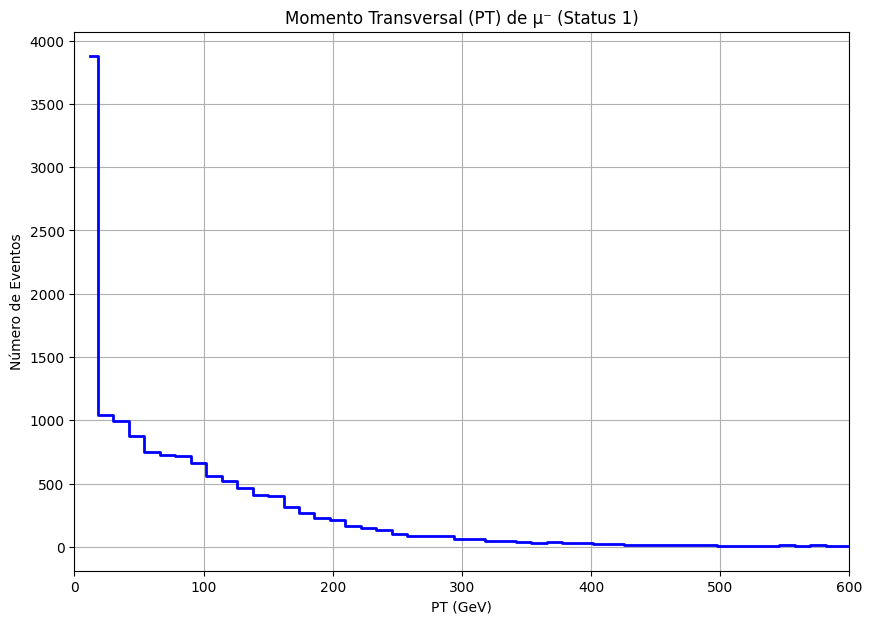

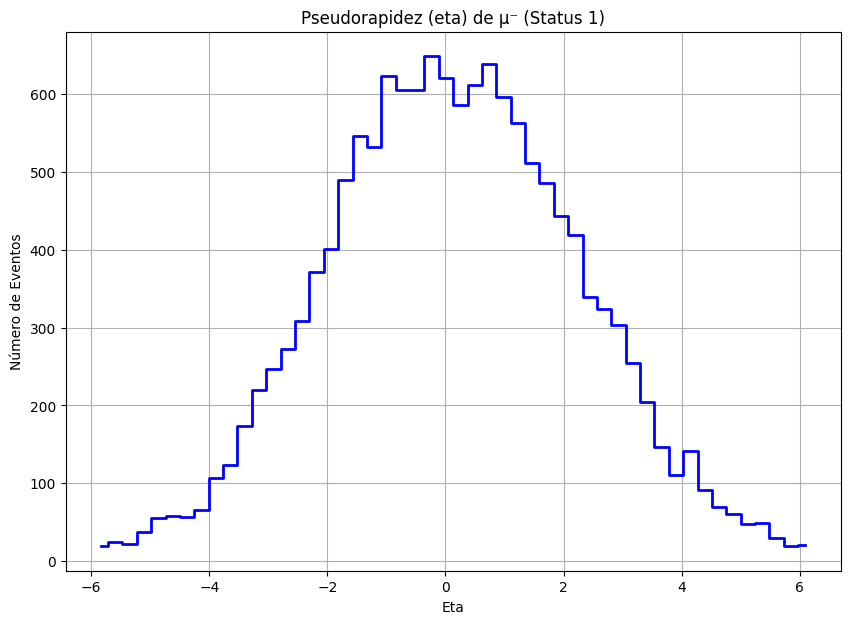

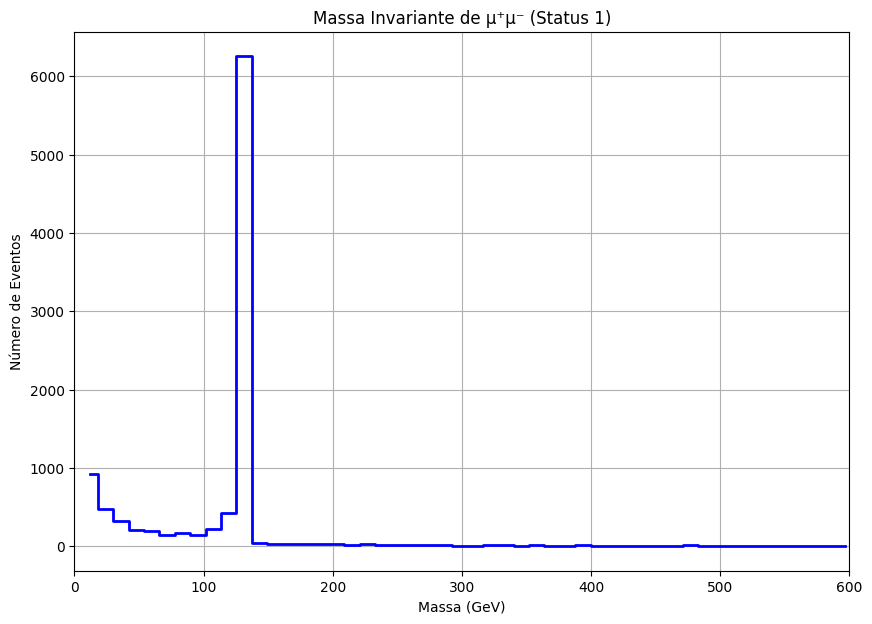

In [2]:
import pyhepmc as hep 
import numpy as np
import matplotlib.pyplot as plt

# Caminho para o arquivo .hepmc
hepmc_file = '/home/lphelipe/Resultados/tag_1_pythia8_events.hepmc' 

# Função para ler o arquivo HEPMC e extrair os eventos com status
def read_hepmc_file(hepmc_file):
    events = []
    with hep.open(hepmc_file) as f:
        for event in f:
            particles_with_status = [(p, p.status) for p in event.particles]  # Extrai partículas e seus status
            events.append(particles_with_status)
    return events

# Função para calcular o momentum transversal (PT)
def get_pt(particle):
    return np.sqrt(particle.momentum.x**2 + particle.momentum.y**2)

# Função para calcular a pseudorapidez (eta)
def get_eta(particle):
    p = np.sqrt(particle.momentum.x**2 + particle.momentum.y**2 + particle.momentum.z**2)  # Momento total
    if p == 0 or np.isclose(particle.momentum.z, p) or np.isclose(particle.momentum.z, -p):
        return np.nan  # Retorna NaN se não puder calcular
    return 0.5 * np.log((p + particle.momentum.z) / (p - particle.momentum.z))

# Função para calcular a massa invariante de duas partículas
def invariant_mass(p1, p2):
    e_tot = p1.momentum.e + p2.momentum.e  # Soma das energias
    px_tot = p1.momentum.x + p2.momentum.x  # Soma dos momentos px
    py_tot = p1.momentum.y + p2.momentum.y  # Soma dos momentos py
    pz_tot = p1.momentum.z + p2.momentum.z  # Soma dos momentos pz
    return np.sqrt(e_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para analisar eventos e calcular distribuições cinemáticas
# Usaremos qualquer status para quarks b, mas status específico para múons
def analyze_events(events, status_muon=1):
    pt_2b, eta_2b, mass_2b = [], [], []
    pt_2mu, eta_2mu, mass_2mu = [], [], []
    pt_mu_plus, eta_mu_plus = [], []
    pt_mu_minus, eta_mu_minus = [], []
    mass_mu_plus_mu_minus = []

    for event in events:
        # Filtrar quarks b (qualquer status)
        b_quarks = [p for p, status in event if abs(p.pid) == 5]
        # Filtrar múons com o status especificado
        muons = [p for p, status in event if abs(p.pid) == 13 and status == status_muon]
        mu_plus = [p for p, status in event if p.pid == -13 and status == status_muon]  # μ⁺ (mu+)
        mu_minus = [p for p, status in event if p.pid == 13 and status == status_muon]  # μ⁻ (mu-)

        # Calcular para 2 b-quarks
        if len(b_quarks) >= 2:
            pt_2b.extend([get_pt(b) for b in b_quarks[:2]])
            eta_2b.extend([get_eta(b) for b in b_quarks[:2]])
            mass_2b.append(invariant_mass(b_quarks[0], b_quarks[1]))

        # Calcular para 2 múons
        if len(muons) >= 2:
            pt_2mu.extend([get_pt(mu) for mu in muons[:2]])
            eta_2mu.extend([get_eta(mu) for mu in muons[:2]])
            mass_2mu.append(invariant_mass(muons[0], muons[1]))

        # Calcular para μ⁺
        if len(mu_plus) >= 1:
            pt_mu_plus.extend([get_pt(mu) for mu in mu_plus])
            eta_mu_plus.extend([get_eta(mu) for mu in mu_plus])

        # Calcular para μ⁻
        if len(mu_minus) >= 1:
            pt_mu_minus.extend([get_pt(mu) for mu in mu_minus])
            eta_mu_minus.extend([get_eta(mu) for mu in mu_minus])

        # Calcular massa invariante para o par μ⁺μ⁻
        if len(mu_plus) >= 1 and len(mu_minus) >= 1:
            mass_mu_plus_mu_minus.append(invariant_mass(mu_plus[0], mu_minus[0]))

    return (pt_2b, eta_2b, mass_2b, 
            pt_2mu, eta_2mu, mass_2mu, 
            pt_mu_plus, eta_mu_plus, 
            pt_mu_minus, eta_mu_minus, 
            mass_mu_plus_mu_minus)

# Função para plotar histogramas individualmente
def plot_histogram(data, title, xlabel, ylabel, bins=50, width=8, height=6, xlim=None):
    # Remove valores não finitos
    data = [d for d in data if np.isfinite(d)]
    
    # Filtrar os dados com base no limite xlim, se definido
    if xlim is not None:
        data = [d for d in data if xlim[0] <= d <= xlim[1]]  # Filtra os dados dentro do limite

    if len(data) == 0:  # Se não houver dados válidos após a filtragem
        print(f"Nenhum dado válido para plotar: {title}")
        return
    
    counts, bin_edges = np.histogram(data, bins=bins)
    plt.figure(figsize=(width, height))
    plt.step(bin_edges[1:], counts, where='mid', color='blue', linewidth=2)  # Desenhar linha do topo
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if xlim is not None:
        plt.xlim(xlim)  # Define os limites do eixo X se especificado
    
    plt.grid(True)
    plt.show()

# Ler eventos do arquivo HEPMC
events = read_hepmc_file(hepmc_file)

# Definir status específico para os múons e usar qualquer status para os quarks b
status_muons = 1  # Exemplo de status para múons

# Analisar eventos e obter distribuições cinemáticas
(pt_2b, eta_2b, mass_2b, 
 pt_2mu, eta_2mu, mass_2mu, 
 pt_mu_plus, eta_mu_plus, 
 pt_mu_minus, eta_mu_minus, 
 mass_mu_plus_mu_minus) = analyze_events(events, status_muon=status_muons)

# Plotar histogramas para 2 b-quarks
plot_histogram(mass_2b, "Massa Invariante de 2 b-quarks (Qualquer Status)", "Massa (GeV)", "Número de Eventos", width=10, height=7, xlim=(0, 600))
plot_histogram(pt_2b, "Momento Transversal (PT) de 2 b-quarks (Qualquer Status)", "PT (GeV)", "Número de Eventos", width=10, height=7, xlim=(0, 600))
plot_histogram(eta_2b, "Pseudorapidez (eta) de 2 b-quarks (Qualquer Status)", "Eta", "Número de Eventos", width=10, height=7)

# Plotar histogramas para 2 múons
plot_histogram(mass_2mu, "Massa Invariante de 2 múons (Status 1)", "Massa (GeV)", "Número de Eventos", width=10, height=7, xlim=(0, 600))
plot_histogram(pt_2mu, "Momento Transversal (PT) de 2 múons (Status 1)", "PT (GeV)", "Número de Eventos", width=10, height=7, xlim=(0, 600))
plot_histogram(eta_2mu, "Pseudorapidez (eta) de 2 múons (Status 1)", "Eta", "Número de Eventos", width=10, height=7)

# Plotar histogramas para μ⁺
plot_histogram(pt_mu_plus, "Momento Transversal (PT) de μ⁺ (Status 1)", "PT (GeV)", "Número de Eventos", width=10, height=7, xlim=(0, 600))
plot_histogram(eta_mu_plus, "Pseudorapidez (eta) de μ⁺ (Status 1)", "Eta", "Número de Eventos", width=10, height=7)

# Plotar histogramas para μ⁻
plot_histogram(pt_mu_minus, "Momento Transversal (PT) de μ⁻ (Status 1)", "PT (GeV)", "Número de Eventos", width=10, height=7, xlim=(0, 600))
plot_histogram(eta_mu_minus, "Pseudorapidez (eta) de μ⁻ (Status 1)", "Eta", "Número de Eventos", width=10, height=7)

# Plotar histograma para massa invariante de μ⁺ e μ⁻
plot_histogram(mass_mu_plus_mu_minus, "Massa Invariante de μ⁺μ⁻ (Status 1)", "Massa (GeV)", "Número de Eventos", width=10, height=7, xlim=(0, 600))


/tmp/ipykernel_78/3649102100.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  return 0.5 * np.log((p + particle.momentum.z) / (p - particle.momentum.z))
/tmp/ipykernel_78/3649102100.py:23: RuntimeWarning: divide by zero encountered in log
  return 0.5 * np.log((p + particle.momentum.z) / (p - particle.momentum.z))


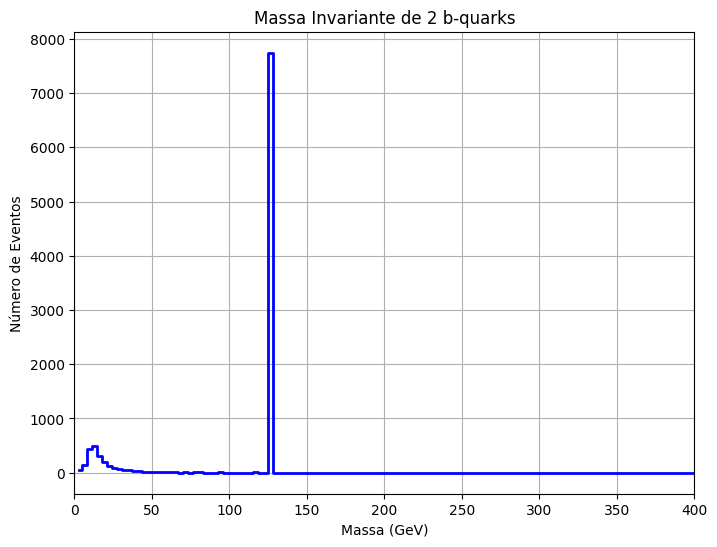

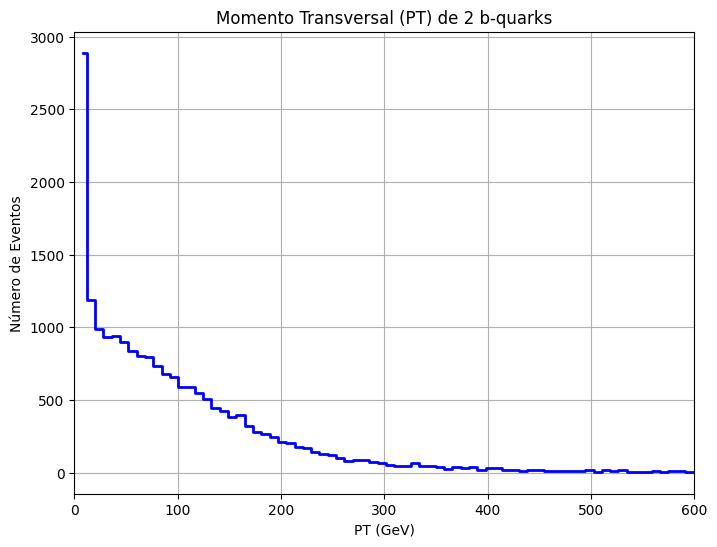

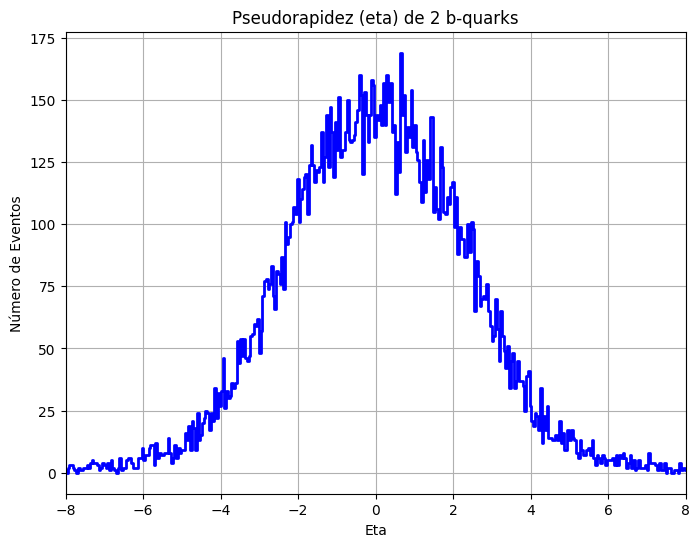

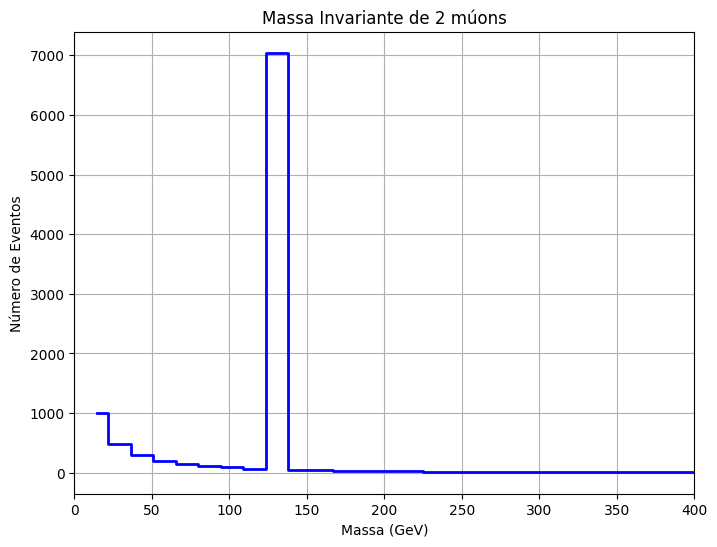

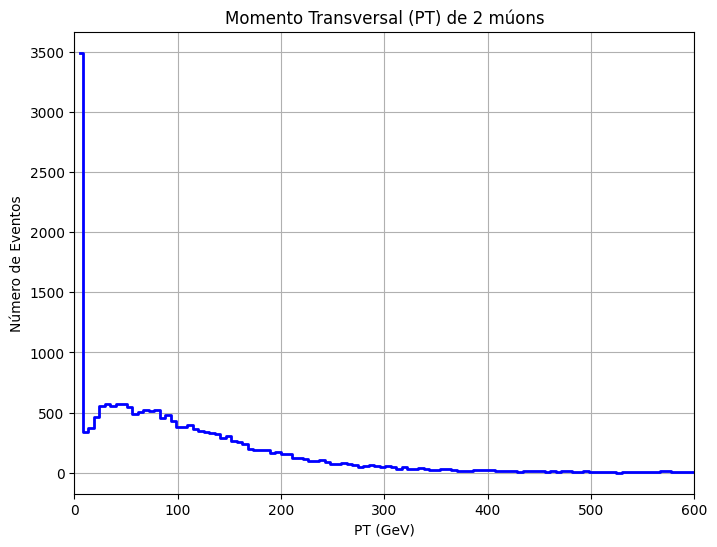

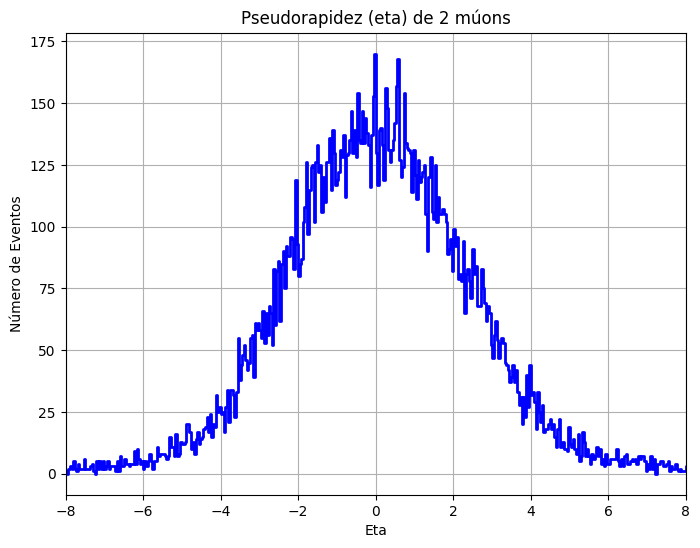

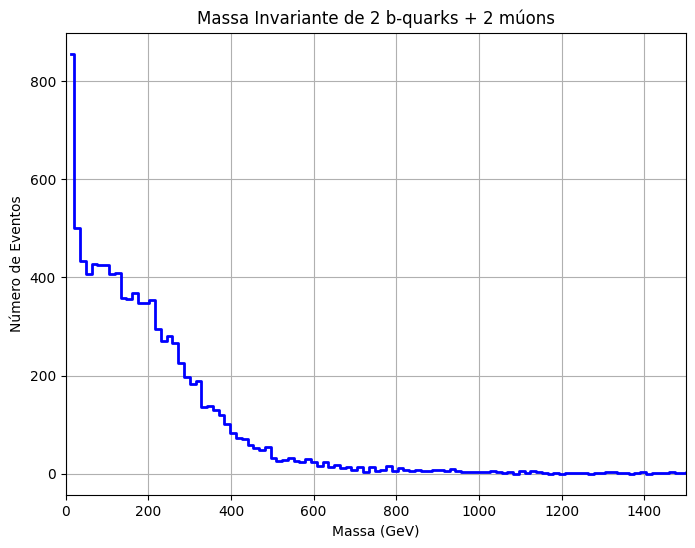

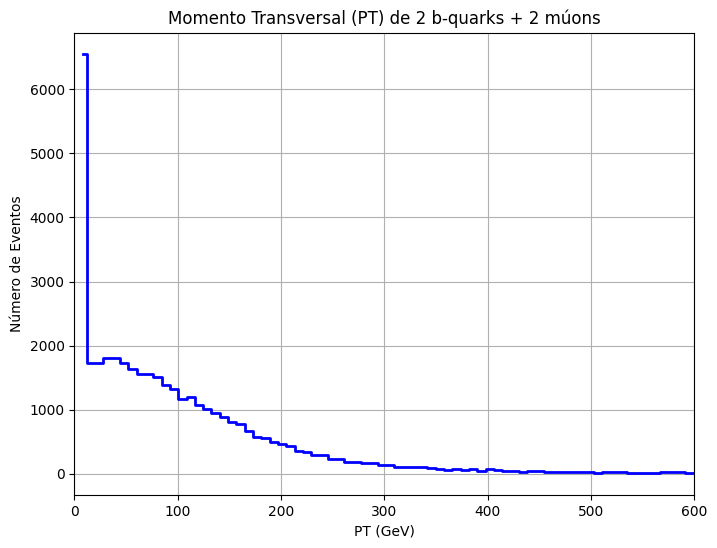

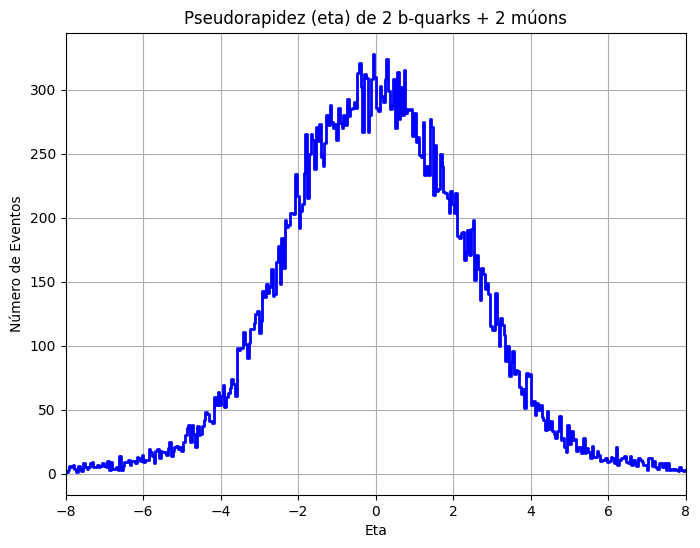

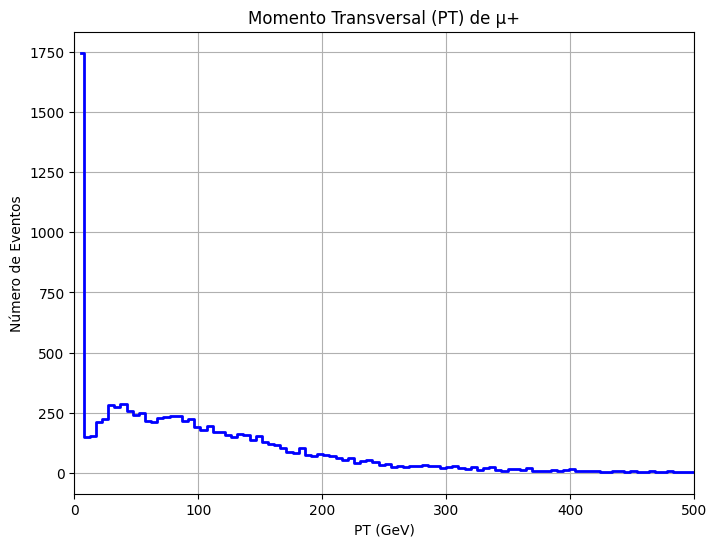

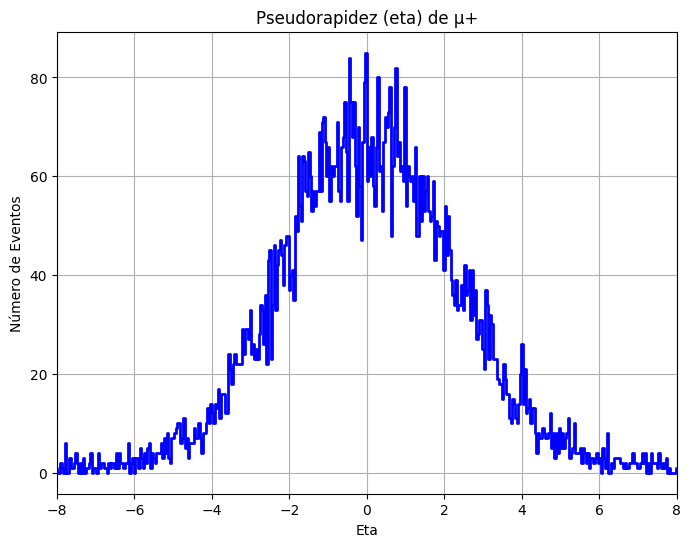

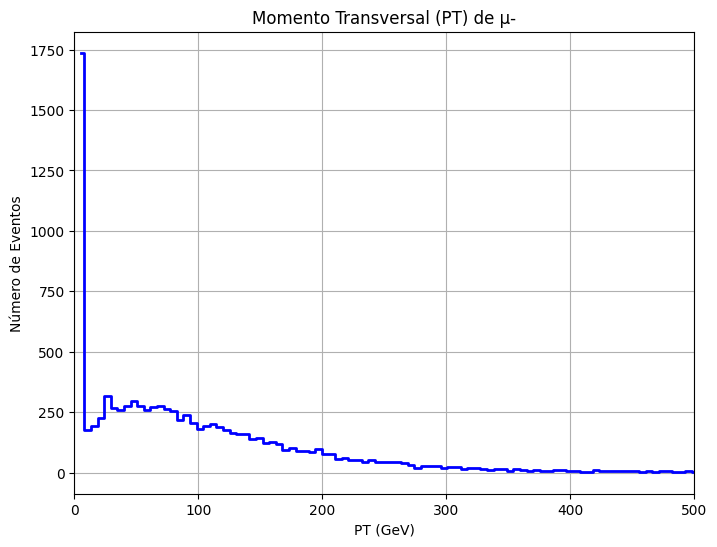

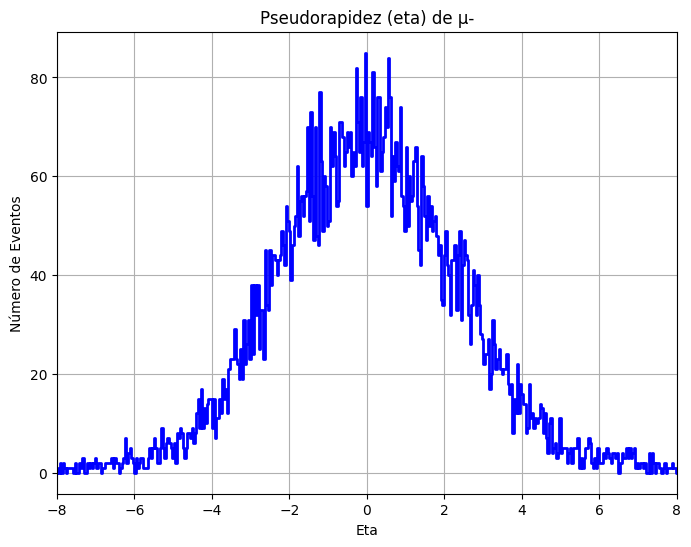

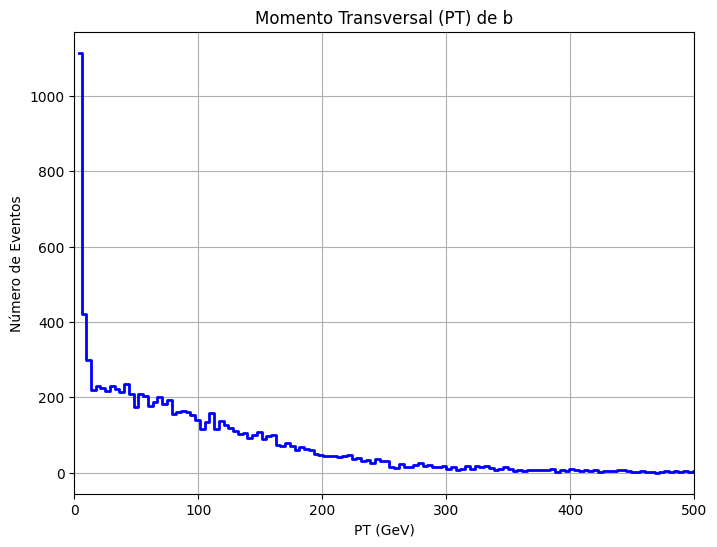

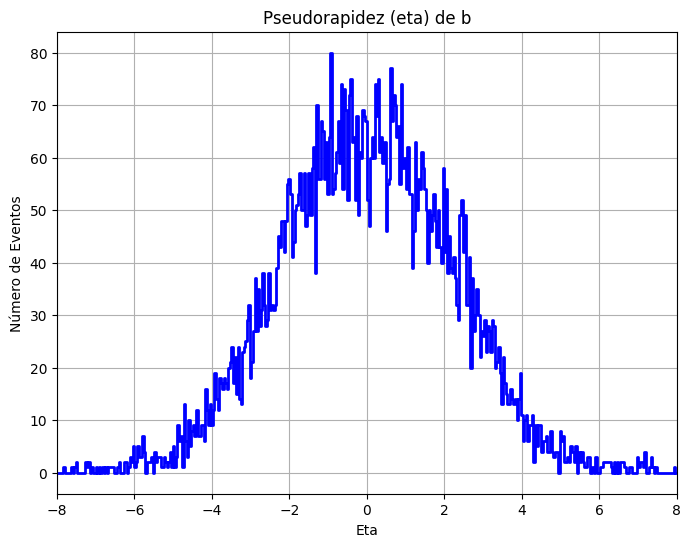

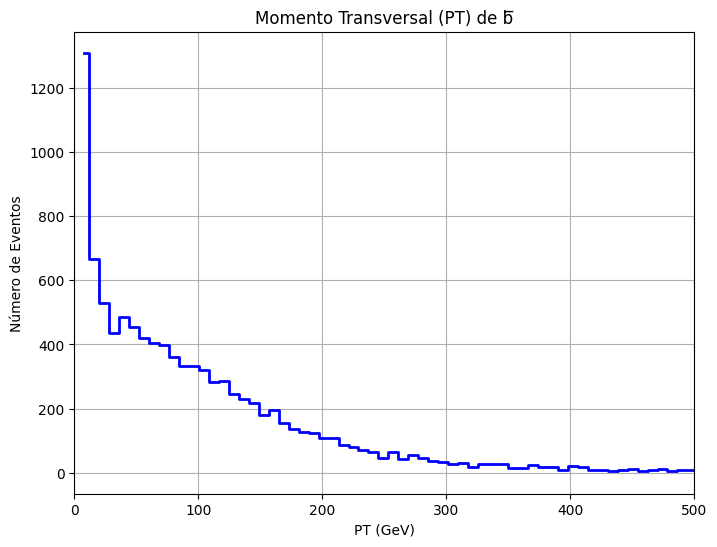

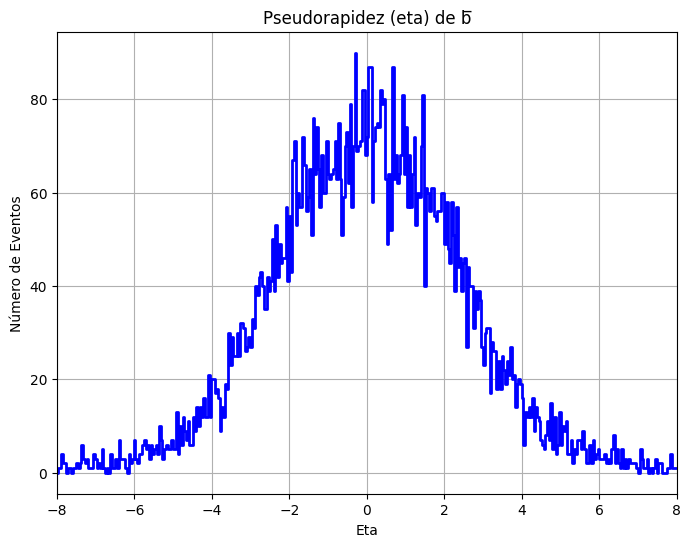

In [7]:
import pyhepmc as hep 
import numpy as np
import matplotlib.pyplot as plt

# Caminho para o arquivo .hepmc
hepmc_file = '/home/lphelipe/Resultados/tag_1_pythia8_events.hepmc' 

# Função para ler o arquivo HEPMC
def read_hepmc_file(hepmc_file):
    events = []
    with hep.open(hepmc_file) as f:
        for event in f:
            events.append(event)
    return events

# Função para calcular o momentum transversal (PT)
def get_pt(particle):
    return np.sqrt(particle.momentum.x**2 + particle.momentum.y**2)

# Função para calcular a pseudorapidez (eta)
def get_eta(particle):
    p = np.sqrt(particle.momentum.x**2 + particle.momentum.y**2 + particle.momentum.z**2)  # Momento total
    return 0.5 * np.log((p + particle.momentum.z) / (p - particle.momentum.z))

# Função para calcular a massa invariante de duas partículas
def invariant_mass(p1, p2):
    e_tot = p1.momentum.e + p2.momentum.e  # Soma das energias
    px_tot = p1.momentum.x + p2.momentum.x  # Soma dos momentos px
    py_tot = p1.momentum.y + p2.momentum.y  # Soma dos momentos py
    pz_tot = p1.momentum.z + p2.momentum.z  # Soma dos momentos pz
    return np.sqrt(e_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para analisar eventos e calcular distribuições cinemáticas
def analyze_events(events):
    pt_2b, eta_2b, mass_2b = [], [], []
    pt_2mu, eta_2mu, mass_2mu = [], [], []
    pt_2b2mu, eta_2b2mu, mass_2b2mu = [], [], []

    # Novas listas para armazenar os resultados de muons e quarks b
    pt_mu_plus, eta_mu_plus, mass_mu_plus = [], [], []
    pt_mu_minus, eta_mu_minus, mass_mu_minus = [], [], []
    pt_b, eta_b, mass_b = [], [], []
    pt_b_bar, eta_b_bar, mass_b_bar = [], [], []

    for event in events:
        b_quarks = [p for p in event.particles if abs(p.pid) == 5]  # Partículas com id 5 ou -5 (b-quarks)
        muons = [p for p in event.particles if abs(p.pid) == 13]  # Partículas com id 13 ou -13 (muons)

        # Calcular para 2 b-quarks
        if len(b_quarks) >= 2:
            pt_2b.extend([get_pt(b) for b in b_quarks[:2]])
            eta_2b.extend([get_eta(b) for b in b_quarks[:2]])
            mass_2b.append(invariant_mass(b_quarks[0], b_quarks[1]))

            # Adicionar dados de b e anti-b
            pt_b.extend([get_pt(b_quarks[0])])
            eta_b.extend([get_eta(b_quarks[0])])
            pt_b_bar.extend([get_pt(b_quarks[1])])
            eta_b_bar.extend([get_eta(b_quarks[1])])

        # Calcular para 2 múons com cargas opostas
        if len(muons) >= 2:
            positive_muons = [mu for mu in muons if mu.pid == 13]  # Múons positivos
            negative_muons = [mu for mu in muons if mu.pid == -13]  # Múons negativos
            
            # Certificar-se de que haja pelo menos um múon positivo e um negativo
            if positive_muons and negative_muons:
                pt_2mu.extend([get_pt(positive_muons[0]), get_pt(negative_muons[0])])
                eta_2mu.extend([get_eta(positive_muons[0]), get_eta(negative_muons[0])])
                mass_2mu.append(invariant_mass(positive_muons[0], negative_muons[0]))

                # Adicionar dados para múons positivos e negativos
                pt_mu_plus.append(get_pt(positive_muons[0]))
                eta_mu_plus.append(get_eta(positive_muons[0]))
                pt_mu_minus.append(get_pt(negative_muons[0]))
                eta_mu_minus.append(get_eta(negative_muons[0]))

        # Calcular para o sistema 2b2mu (considerando 2 quarks b e 2 múons)
        if len(b_quarks) >= 2 and len(muons) >= 2:
            pt_2b2mu.extend([get_pt(b_quarks[0]), get_pt(b_quarks[1]), 
                             get_pt(positive_muons[0]), get_pt(negative_muons[0])])
            eta_2b2mu.extend([get_eta(b_quarks[0]), get_eta(b_quarks[1]), 
                              get_eta(positive_muons[0]), get_eta(negative_muons[0])])
            mass_2b2mu.append(invariant_mass(b_quarks[0], positive_muons[0]))  # Massa entre 1 b e 1 muon (exemplo)

    return (pt_2b, eta_2b, mass_2b, 
            pt_2mu, eta_2mu, mass_2mu, 
            pt_2b2mu, eta_2b2mu, mass_2b2mu,
            pt_mu_plus, eta_mu_plus, mass_mu_plus,
            pt_mu_minus, eta_mu_minus, mass_mu_minus,
            pt_b, eta_b, mass_b,
            pt_b_bar, eta_b_bar, mass_b_bar)

# Função para plotar histogramas individualmente
def plot_histogram(data, title, xlabel, ylabel, bins=500, xlim=None):
    data = np.array(data)  # Converte para numpy array
    data = data[np.isfinite(data)]  # Remove valores não finitos
    if len(data) == 0:  # Verifica se a lista está vazia
        print(f"Nenhum dado válido para plotar: {title}")
        return
    counts, bin_edges = np.histogram(data, bins=bins)
    plt.figure(figsize=(8, 6))
    plt.step(bin_edges[1:], counts, where='mid', color='blue', linewidth=2)  # Desenhar linha do topo
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    
    # Configurar limites do eixo x, se fornecido
    if xlim is not None:
        plt.xlim(xlim)

    plt.show()

# Ler eventos do arquivo HEPMC
events = read_hepmc_file(hepmc_file)

# Analisar eventos e obter distribuições cinemáticas
(pt_2b, eta_2b, mass_2b, 
 pt_2mu, eta_2mu, mass_2mu, 
 pt_2b2mu, eta_2b2mu, mass_2b2mu,
 pt_mu_plus, eta_mu_plus, mass_mu_plus,
 pt_mu_minus, eta_mu_minus, mass_mu_minus,
 pt_b, eta_b, mass_b,
 pt_b_bar, eta_b_bar, mass_b_bar) = analyze_events(events)

# Plotar histogramas para 2 b-quarks
plot_histogram(mass_2b, "Massa Invariante de 2 b-quarks", "Massa (GeV)", "Número de Eventos", xlim=(0, 400))
plot_histogram(pt_2b, "Momento Transversal (PT) de 2 b-quarks", "PT (GeV)", "Número de Eventos", xlim=(0, 600))
plot_histogram(eta_2b, "Pseudorapidez (eta) de 2 b-quarks", "Eta", "Número de Eventos", xlim=(-8, 8))

# Plotar histogramas para 2 múons com cargas opostas
plot_histogram(mass_2mu, "Massa Invariante de 2 múons", "Massa (GeV)", "Número de Eventos", xlim=(0, 400))
plot_histogram(pt_2mu, "Momento Transversal (PT) de 2 múons", "PT (GeV)", "Número de Eventos", xlim=(0, 600))
plot_histogram(eta_2mu, "Pseudorapidez (eta) de 2 múons", "Eta", "Número de Eventos", xlim=(-8, 8))

# Plotar histogramas para 2b2mu
plot_histogram(mass_2b2mu, "Massa Invariante de 2 b-quarks + 2 múons", "Massa (GeV)", "Número de Eventos", xlim=(0, 1500))
plot_histogram(pt_2b2mu, "Momento Transversal (PT) de 2 b-quarks + 2 múons", "PT (GeV)", "Número de Eventos", xlim=(0, 600))
plot_histogram(eta_2b2mu, "Pseudorapidez (eta) de 2 b-quarks + 2 múons", "Eta", "Número de Eventos", xlim=(-8, 8))

# Plotar histogramas para múons positivos e negativos
plot_histogram(pt_mu_plus, "Momento Transversal (PT) de μ+", "PT (GeV)", "Número de Eventos", xlim=(0, 500))
plot_histogram(eta_mu_plus, "Pseudorapidez (eta) de μ+", "Eta", "Número de Eventos", xlim=(-8, 8))

plot_histogram(pt_mu_minus, "Momento Transversal (PT) de μ-", "PT (GeV)", "Número de Eventos", xlim=(0, 500))
plot_histogram(eta_mu_minus, "Pseudorapidez (eta) de μ-", "Eta", "Número de Eventos", xlim=(-8, 8))

# Plotar histogramas para quarks b e anti-b
plot_histogram(pt_b, "Momento Transversal (PT) de b", "PT (GeV)", "Número de Eventos", xlim=(0, 500))
plot_histogram(eta_b, "Pseudorapidez (eta) de b", "Eta", "Número de Eventos", xlim=(-8, 8))

plot_histogram(pt_b_bar, "Momento Transversal (PT) de b̅", "PT (GeV)", "Número de Eventos", xlim=(0, 500))
plot_histogram(eta_b_bar, "Pseudorapidez (eta) de b̅", "Eta", "Número de Eventos", xlim=(-8, 8))

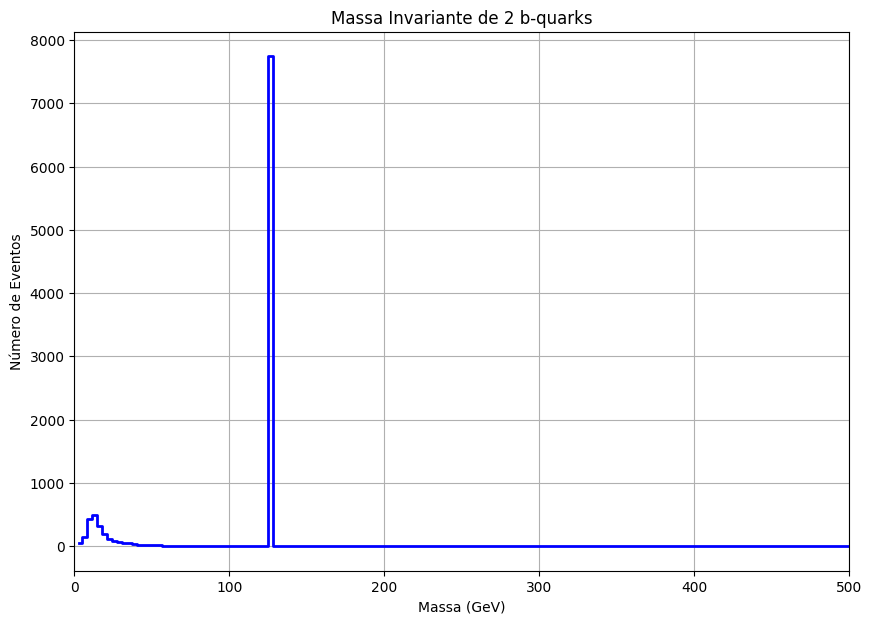

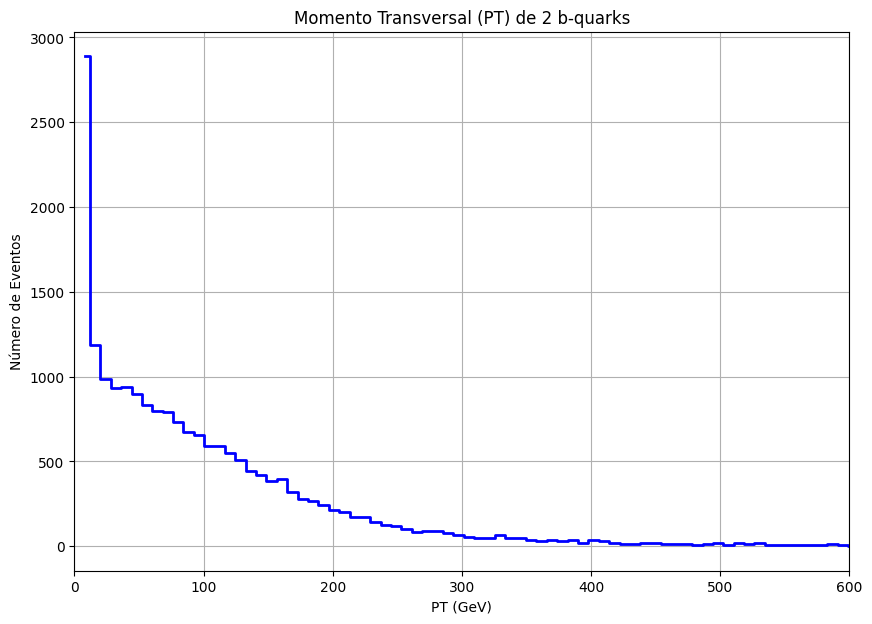

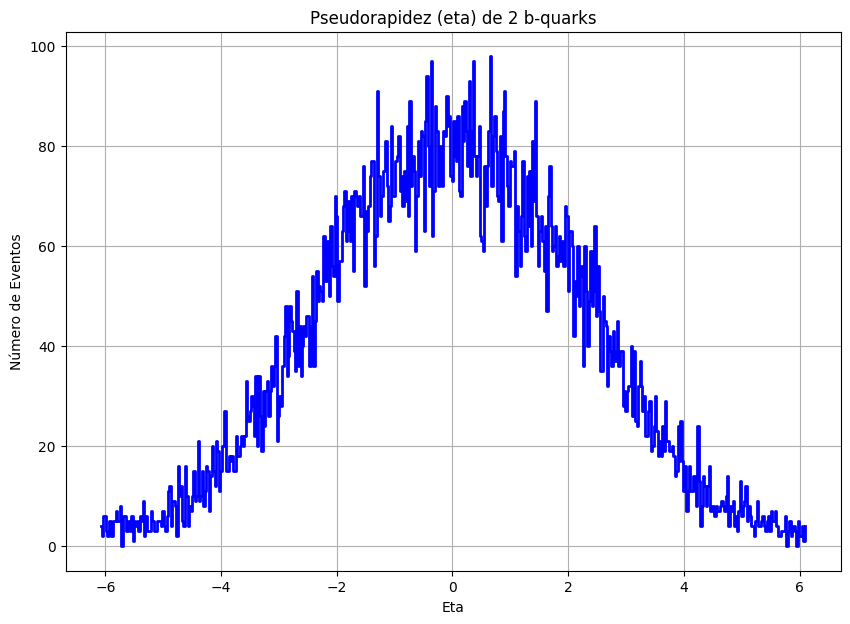

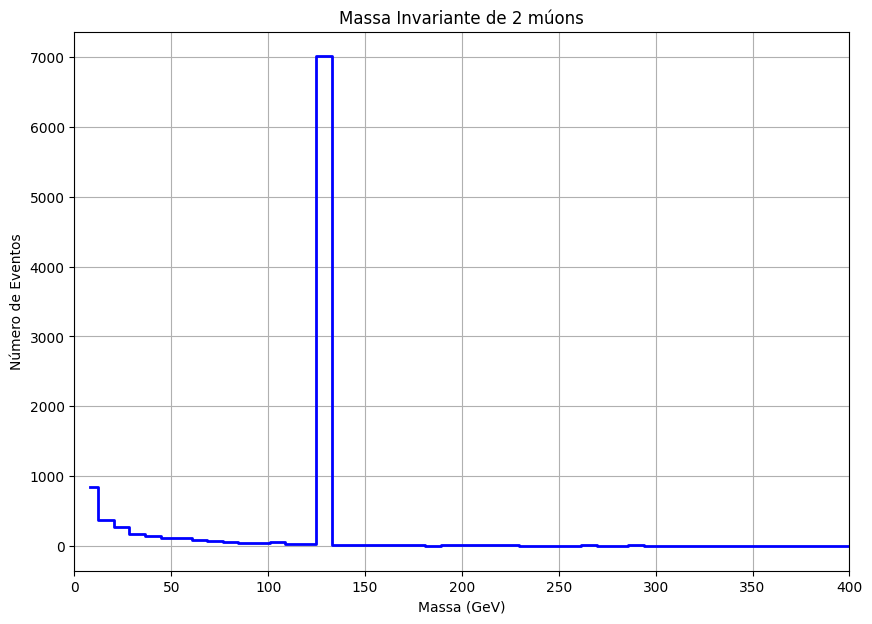

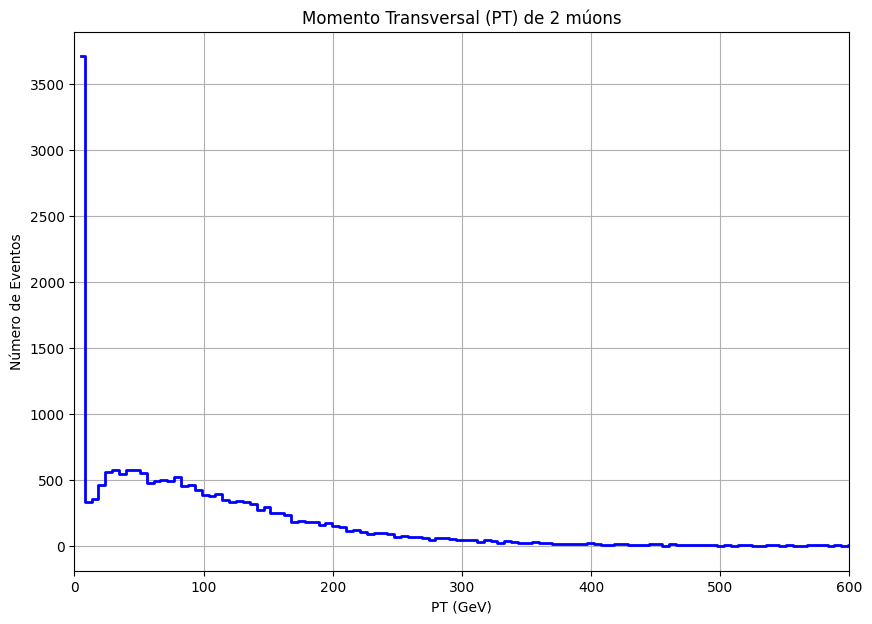

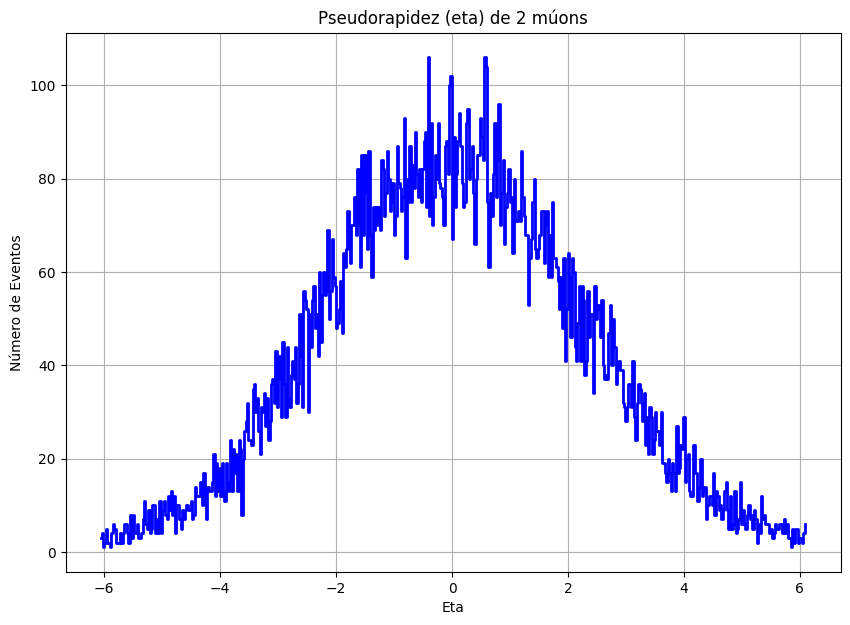

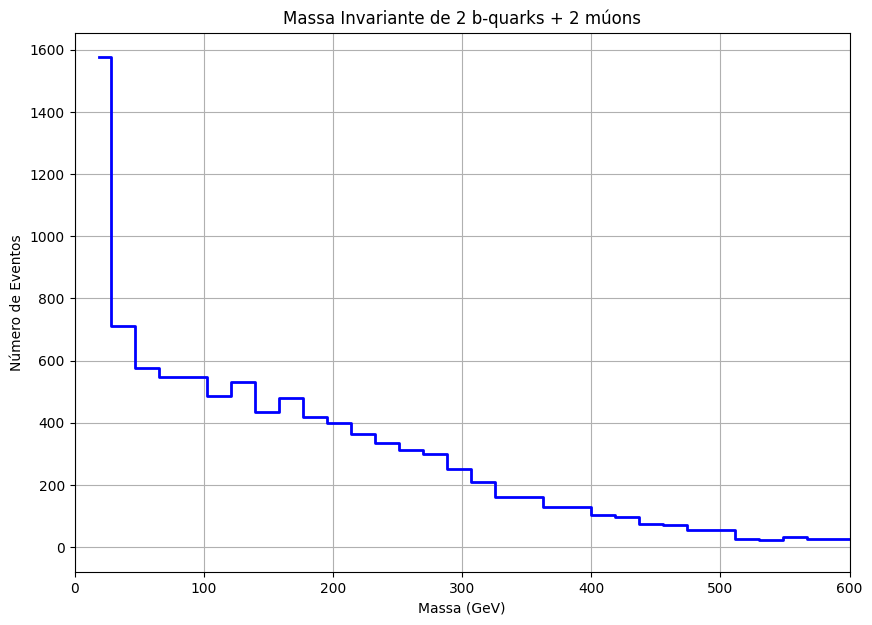

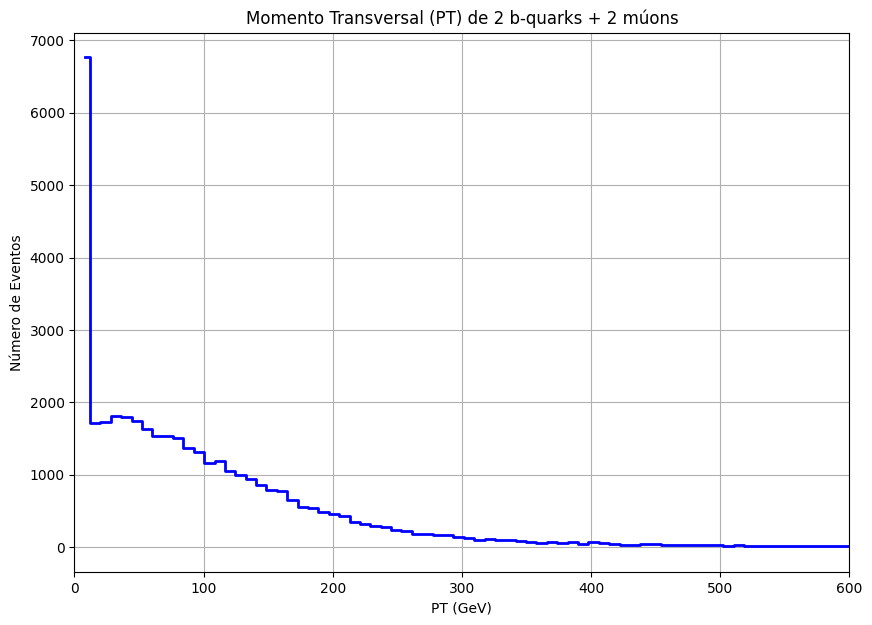

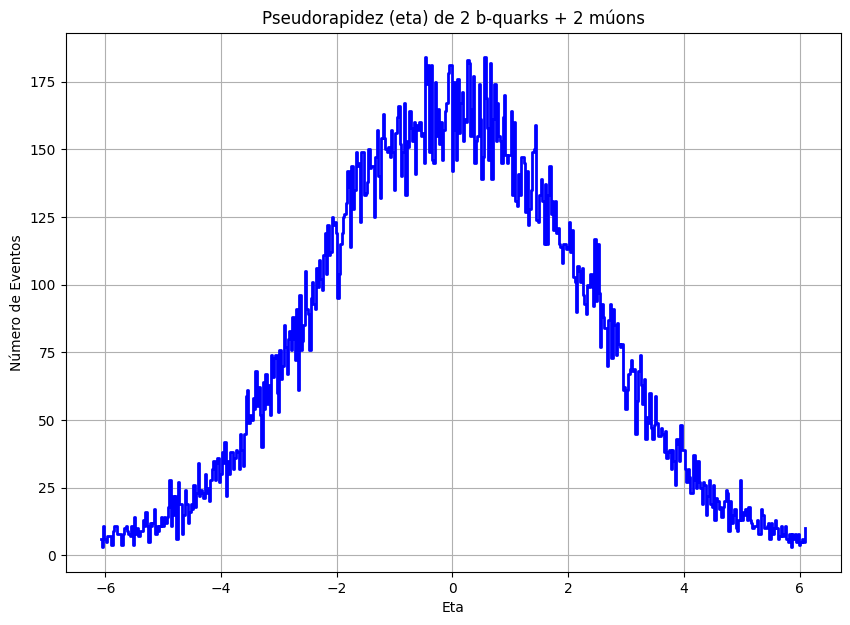

In [2]:
import pyhepmc as hep 
import numpy as np
import matplotlib.pyplot as plt

# Caminho para o arquivo .hepmc
hepmc_file = '/home/lphelipe/Resultados/tag_1_pythia8_events.hepmc' 

# Função para ler o arquivo HEPMC
def read_hepmc_file(hepmc_file):
    events = []
    with hep.open(hepmc_file) as f:
        for event in f:
            events.append(event)
    return events

# Função para calcular o momentum transversal (PT)
def get_pt(particle):
    return np.sqrt(particle.momentum.x**2 + particle.momentum.y**2)

# Função para calcular a pseudorapidez (eta)
def get_eta(particle):
    p = np.sqrt(particle.momentum.x**2 + particle.momentum.y**2 + particle.momentum.z**2)  # Momento total
    if p == 0 or np.isclose(particle.momentum.z, p) or np.isclose(particle.momentum.z, -p):
        return np.nan  # Retorna NaN se não puder calcular
    return 0.5 * np.log((p + particle.momentum.z) / (p - particle.momentum.z))

# Função para calcular a massa invariante de duas partículas
def invariant_mass(p1, p2):
    e_tot = p1.momentum.e + p2.momentum.e  # Soma das energias
    px_tot = p1.momentum.x + p2.momentum.x  # Soma dos momentos px
    py_tot = p1.momentum.y + p2.momentum.y  # Soma dos momentos py
    pz_tot = p1.momentum.z + p2.momentum.z  # Soma dos momentos pz
    return np.sqrt(e_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para analisar eventos e calcular distribuições cinemáticas
def analyze_events(events):
    pt_2b, eta_2b, mass_2b = [], [], []
    pt_2mu, eta_2mu, mass_2mu = [], [], []
    pt_2b2mu, eta_2b2mu, mass_2b2mu = [], [], []

    for event in events:
        b_quarks = [p for p in event.particles if abs(p.pid) == 5]  # Partículas com id 5 ou -5 (b-quarks)
        muons = [p for p in event.particles if abs(p.pid) == 13]  # Partículas com id 13 ou -13 (muons)

        # Calcular para 2 b-quarks
        if len(b_quarks) >= 2:
            pt_2b.extend([get_pt(b) for b in b_quarks[:2]])
            eta_2b.extend([get_eta(b) for b in b_quarks[:2]])
            mass_2b.append(invariant_mass(b_quarks[0], b_quarks[1]))

        # Calcular para 2 múons
        if len(muons) >= 2:
            pt_2mu.extend([get_pt(mu) for mu in muons[:2]])
            eta_2mu.extend([get_eta(mu) for mu in muons[:2]])
            mass_2mu.append(invariant_mass(muons[0], muons[1]))

        # Calcular para o sistema 2b2mu (considerando 2 quarks b e 2 múons)
        if len(b_quarks) >= 2 and len(muons) >= 2:
            pt_2b2mu.extend([get_pt(b_quarks[0]), get_pt(b_quarks[1]), get_pt(muons[0]), get_pt(muons[1])])
            eta_2b2mu.extend([get_eta(b_quarks[0]), get_eta(b_quarks[1]), get_eta(muons[0]), get_eta(muons[1])])
            mass_2b2mu.append(invariant_mass(b_quarks[0], muons[0]))  # Massa entre 1 b e 1 muon (exemplo)

    return (pt_2b, eta_2b, mass_2b, 
            pt_2mu, eta_2mu, mass_2mu, 
            pt_2b2mu, eta_2b2mu, mass_2b2mu)

# Função para plotar histogramas individualmente
def plot_histogram(data, title, xlabel, ylabel, bins=500, width=8, height=6, xlim=None):
    # Remove valores não finitos
    data = [d for d in data if np.isfinite(d)]
    if len(data) == 0:  # Se não houver dados válidos
        print(f"Nenhum dado válido para plotar: {title}")
        return
    counts, bin_edges = np.histogram(data, bins=bins)
    plt.figure(figsize=(width, height))
    plt.step(bin_edges[1:], counts, where='mid', color='blue', linewidth=2)  # Desenhar linha do topo
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xlim is not None:
        plt.xlim(xlim)  # Define os limites do eixo X se especificado
    plt.grid(True)
    plt.show()

# Ler eventos do arquivo HEPMC
events = read_hepmc_file(hepmc_file)

# Analisar eventos e obter distribuições cinemáticas
(pt_2b, eta_2b, mass_2b, 
 pt_2mu, eta_2mu, mass_2mu, 
 pt_2b2mu, eta_2b2mu, mass_2b2mu) = analyze_events(events)

# Plotar histogramas para 2 b-quarks
plot_histogram(mass_2b, "Massa Invariante de 2 b-quarks", "Massa (GeV)", "Número de Eventos", width=10, height=7, xlim=(0, 500))
plot_histogram(pt_2b, "Momento Transversal (PT) de 2 b-quarks", "PT (GeV)", "Número de Eventos", width=10, height=7, xlim=(0, 600))
plot_histogram(eta_2b, "Pseudorapidez (eta) de 2 b-quarks", "Eta", "Número de Eventos", width=10, height=7)

# Plotar histogramas para 2 múons
plot_histogram(mass_2mu, "Massa Invariante de 2 múons", "Massa (GeV)", "Número de Eventos", width=10, height=7, xlim=(0, 400))
plot_histogram(pt_2mu, "Momento Transversal (PT) de 2 múons", "PT (GeV)", "Número de Eventos", width=10, height=7, xlim=(0, 600))
plot_histogram(eta_2mu, "Pseudorapidez (eta) de 2 múons", "Eta", "Número de Eventos", width=10, height=7)

# Plotar histogramas para 2b2mu
plot_histogram(mass_2b2mu, "Massa Invariante de 2 b-quarks + 2 múons", "Massa (GeV)", "Número de Eventos", width=10, height=7, xlim=(0, 600))
plot_histogram(pt_2b2mu, "Momento Transversal (PT) de 2 b-quarks + 2 múons", "PT (GeV)", "Número de Eventos", width=10, height=7, xlim=(0, 600))
plot_histogram(eta_2b2mu, "Pseudorapidez (eta) de 2 b-quarks + 2 múons", "Eta", "Número de Eventos", width=10, height=7)
